### Automatic watermark removal
This is the Jupyter notebook for automatic watermark removal code.
We follow the scripts till watermark estimation and then try to solve the watermarking problem.

https://github.com/jackliusr/automatic-watermark-detection.git


In [1]:
!  rm -rf *
! git clone --depth 1 -- https://github.com/jackliusr/automatic-watermark-detection.git wm

Cloning into 'wm'...
remote: Enumerating objects: 55, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 55 (delta 5), reused 40 (delta 3), pack-reused 0
Unpacking objects: 100% (55/55), done.


Computing gradients.
Computing median gradients.


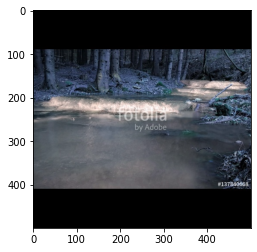

In [6]:
%matplotlib inline
from  wm.src import *

gx, gy, gxlist, gylist = estimate_watermark('/content/wm/images/fotolia_processed')


est = poisson_reconstruct(gx, gy)
cropped_gx, cropped_gy = crop_watermark(gx, gy)
est2 = poisson_reconstruct(cropped_gx, cropped_gy)

# random photo
img = cv2.imread('/content/wm/images/fotolia_processed/fotolia_137840668.jpg')

plt.imshow(img)
im, start, end = watermark_detector(img, cropped_gx, cropped_gy)

# plt.imshow(im)
# plt.show()

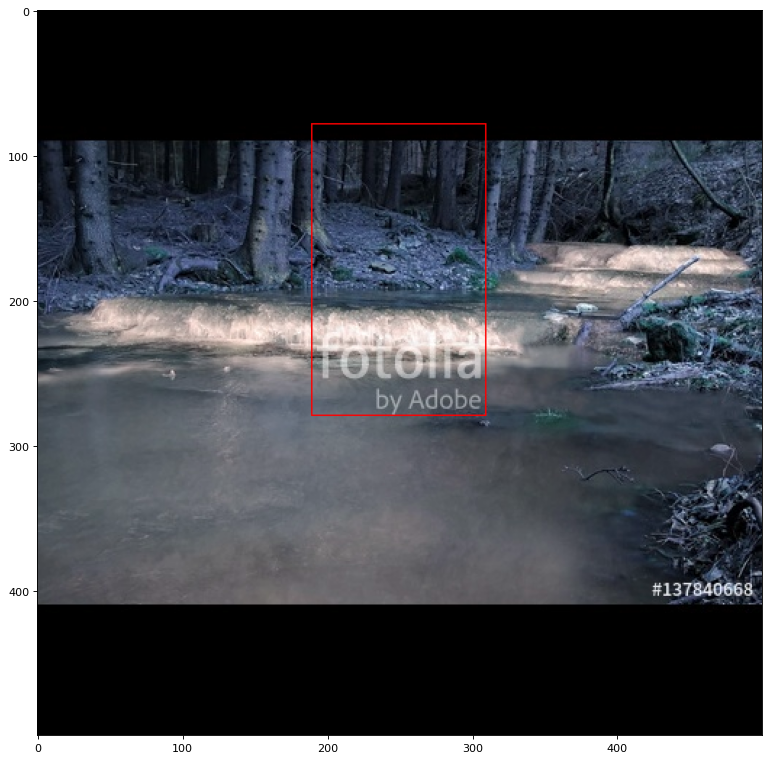

In [7]:
plt.figure(figsize=(12, 12), dpi= 80, facecolor='w', edgecolor='k')
plt.imshow(im)

In [8]:
print(cropped_gx.shape, cropped_gy.shape, est.shape, est2.shape)
print(im.shape, start, end)

(201, 120, 3) (201, 120, 3) (500, 500, 3) (201, 120, 3)
(500, 500, 3) (78, 189) (201, 120)


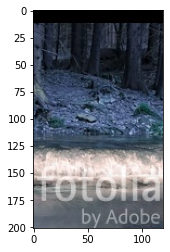

In [9]:
plt.imshow(img[start[0]:(start[0]+end[0]), start[1]:(start[1]+end[1]), :])

In [13]:
'''
This is the part where we get all the images, extract their parts, and then add it to our matrix
'''
num_images = len(gxlist)
images_cropped = np.zeros((num_images,) + cropped_gx.shape)

# get images
foldername = '/content/wm/images/fotolia_processed'

# Store all the watermarked images
# start, and end are already stored
# just crop and store image
image_paths = []
_s, _e = start, end
index = 0

# Iterate over all images
for r, dirs, files in os.walk(foldername):

    for file in files:
        _img = cv2.imread(os.sep.join([r, file]))
        if _img is not None:
            # estimate the watermark part
            image_paths.append(os.sep.join([r, file]))
            _img = _img[_s[0]:(_s[0]+_e[0]), _s[1]:(_s[1]+_e[1]), :]
            # add to list images
            images_cropped[index, :, :, :] = _img
            index+=1
        else:
            print("%s not found."%(file))

IndexError: ignored

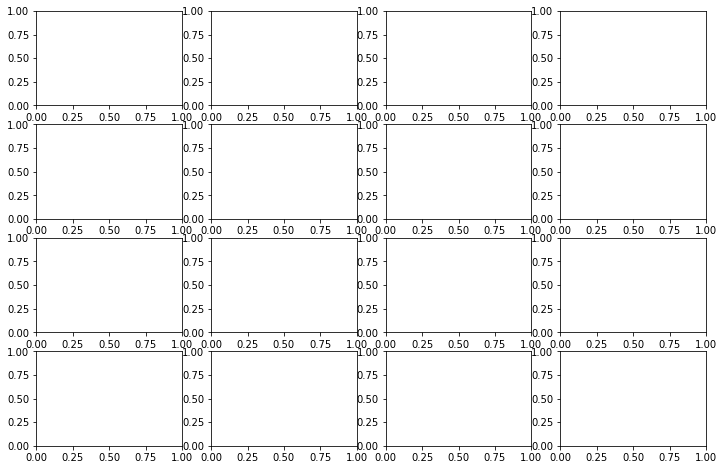

In [12]:
# Print some random indices extracted
N = 4
random_indices = np.random.randint(index, size=(N*N,))
fig, axes = plt.subplots(N, N, figsize=(12, 8))
for i, val in enumerate(random_indices):
    axes[i/N, i%N].imshow(images_cropped[val])

### Image reconstruction
Here comes the tougher part. We have an initial estimate for the watermark `Wm, cropped_gx, cropped_gy` and `est`. Using this, we solve the problem of Multi-image matting and reconstruction. We have a list of images, `images_cropped`, and we have to estimate `W` and `alpha` by reiterating the following 3 steps: 
- Image-Watermark detection
- Watermark update
- Matte update

Finally, we do a Matte and blend factor initialization to determine the constant and normalized matte.

In [ ]:
import tensorflow as tf

In [ ]:
# helpers that are going to be useful here
sobel_x = tf.constant([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], tf.float32)
sobel_y = tf.transpose(sobel_x)

sobel_x_filter = tf.stack([sobel_x, sobel_x, sobel_x])
sobel_x_filter = tf.stack([sobel_x_filter, sobel_x_filter, sobel_x_filter])

sobel_y_filter = tf.stack([sobel_y, sobel_y, sobel_y])
sobel_y_filter = tf.stack([sobel_y_filter, sobel_y_filter, sobel_y_filter])

def phi_func(mtensor, epsilon=0.001):
    return tf.sqrt(mtensor + epsilon**2)
    
# E_data
def E_data(I, W, J, alpha):
    est_error = tf.multiply(alpha, W) + tf.multiply(1-alpha, I) - J
    est_error = phi_func(tf.square(est_error))
    est_error = tf.reduce_sum(est_error)
    return est_error

# regularizer term for I, W
def E_reg(I, alpha):
    alpha_ = tf.expand_dims(alpha, 0)
    ax = tf.nn.conv2d(alpha_, sobel_x_filter, strides=[1, 1, 1, 1], padding="SAME")
    ay = tf.nn.conv2d(alpha_, sobel_y_filter, strides=[1, 1, 1, 1], padding="SAME")
    Ix2 = tf.square(tf.nn.conv2d(I, sobel_x_filter, strides=[1, 1, 1, 1], padding="SAME"))
    Iy2 = tf.square(tf.nn.conv2d(I, sobel_y_filter, strides=[1, 1, 1, 1], padding="SAME"))
    est_error = tf.multiply(tf.abs(ax), Ix2) + tf.multiply(tf.abs(ay), Iy2)
    est_error = tf.reduce_sum(phi_func(est_error))
    return est_error

# regularization term for alpha
def E_reg_alpha(alpha):
    alpha_ = tf.expand_dims(alpha, 0)
    ax2 = tf.square(tf.nn.conv2d(alpha_, sobel_x_filter, strides=[1, 1, 1, 1], padding="SAME"))
    ay2 = tf.square(tf.nn.conv2d(alpha_, sobel_y_filter, strides=[1, 1, 1, 1], padding="SAME"))
    est_error = tf.reduce_sum(phi_func(ax2 + ay2))
    return est_error

# fidelity term
# W = all watermarks
def E_f(alpha, W, W_m):
    aW = tf.multiply(alpha, W)
    # find edge map of alpha*W
    aWx = tf.nn.conv2d(aW, sobel_x_filter, strides=[1, 1, 1, 1], padding="SAME")
    aWy = tf.nn.conv2d(aW, sobel_y_filter, strides=[1, 1, 1, 1], padding="SAME")
    aW_ = tf.sqrt(tf.square(aWx) + tf.square(aWy))
    
    # find edge map of W_m
    W_m__ = tf.expand_dims(W_m, 0)
    W_mx = tf.nn.conv2d(W_m__, sobel_x_filter, strides=[1, 1, 1, 1], padding="SAME")
    W_my = tf.nn.conv2d(W_m__, sobel_y_filter, strides=[1, 1, 1, 1], padding="SAME")
    W_m_ = tf.sqrt(tf.square(W_mx) + tf.square(W_my))
    
    return tf.reduce_sum(phi_func(tf.square(aW_ - W_m_)))

# auxiliary term
def E_aux(W, W_k):
    return tf.reduce_sum(tf.abs(W - W_k))


# We try to use Tensorflow to perform the 3 steps
def image_watermark_decompose_model(num_images, m, n, chan=3, l_i=1, l_w=1, l_alpha=1, beta=1, gamma=1):
    # We have the following parameters
    # num_images = number of images, m, n, number of channels
    # lambda_i, lambda_w, lambda_alpha, beta, and gamma are parameters
    # Input to network: 
    #    J(k) = (num_images, m, n, chan) -> all the images
    #    W_m = (m, n, chan)   -> estimate of the watermark obtained before
    #    W_median =   (m, n, chan)   -> new estimate of W
    #    alpha = (m, n, chan) -> estimate of alpha matte
    # Entities to estimate
    #    I(k) = (num_images, m, n, chan) -> all watermarked images
    #    W(k) = (num_images, m, n, chan) -> all watermarks
    
    # All placeholders
    J = tf.placeholder(tf.float32, shape=(num_images, m, n, chan), name='J')
    alpha = tf.placeholder(tf.float32, shape=(m, n, chan), name='alpha')
    W_m = tf.placeholder(tf.float32, shape=(m, n, chan), name='W_m')
    W_median = tf.placeholder(tf.float32, shape=(m, n, chan), name='W_median')
    
    # All variables
    I = tf.Variable(np.random.randn(num_images, m, n, chan), name='I', dtype=tf.float32)
    W = tf.Variable(np.random.randn(num_images, m, n, chan), name='W', dtype=tf.float32)
    
    # compute loss
    loss = E_data(I, W, J, alpha) + l_i*E_reg(I, alpha) + l_w*E_reg(W, alpha) \
            + beta*E_f(alpha, W, W_m) + gamma*E_aux(W_median, W)
    
    optimizer = tf.train.GradientDescentOptimizer(0.01).minimize(loss)
    return {
        'J': J,
        'alpha': alpha,
        'W_m': W_m,
        'W_median': W_median, 
        'I': I,
        'W': W,
        'loss': loss,
        'step': optimizer,
    }
    
    

In [ ]:
num_images, m, n, chan = images_cropped.shape
model = image_watermark_decompose_model(num_images, m, n, chan)

In [ ]:
# define the variables
# plt.imshow(PlotImage(est2))
W_m = est2
J = images_cropped
I = np.random.randn(num_images, m, n, chan)
alpha = np.random.rand(m, n, chan)
W_median = W_m.copy()
W = np.stack([W_m for _ in xrange(num_images)])
print
saver = tf.train.Saver()
with tf.Session() as sess:
    for i in xrange(100):
        print("Start")
        _, loss = sess.run([model['step'], model['loss']], feed_dict={
            model['J']: J,
            model['alpha']: alpha,
            model['W_m']: W_m,
            model['W_median']: W_median,
        })
        print(loss)
    
